# Connect-Four Game

Connect-four is a board game with a $6\times 7$ grid. Each player has $21$ checkers distinguished by black (B) and red (R) colors. The board is a vertical board and player can only drop their checkers from the top in any of the $7$ columns if the column is not full.

Each player alternate dropping a checker from the top until:

* A player makes a row, a column, or a diagonal set of $4$ checkers.
* No moves left and no sets are made by any player. This case is a draw.

We first set up a game which can be used for human-versus-human play. Then, we explain the Monte Carlo Tree Search (MCTS) algorithm and use it for human-versus-machine and machine-versus-machine plays.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
players={1: "B", -1: "R", 0: "."}

def print_state(state):
    print("\n\t", end="")
    print("\n\t".join("  ".join([players[col] for col in row]) for row in state))
    print()

## Connect-Four Game Setup

We first set up a human-versus-human play. The algorithm calculates when a player wins or there's no move to make (draw) and terminates the game.

In [36]:
class Connect4(object):
    def __init__(self):
        # Grid shape.
        self.nrows = 6
        self.ncols = 7
        # number of connections to be made for winning.
        self.k = 4
        self.first_player = 1

    def init_state(self):
        return np.zeros((self.nrows, self.ncols), dtype=np.int8)

    def next_state(self, state, action, player):
        '''
        Returns the new state resulted by applying `action` taken by `player`
        on the current `state`.
        '''
        col = action
        row = np.argwhere(state[:, col] == 0)[-1][0]
        state[row, col] = player
        return state
    
    def available_actions(self, state):
        return np.where(state[0, :] == 0)[0]

    def opponent(self, player):
        return -player

    def opponent_reward(self, reward):
        return -reward
    
    def neutral_perspective(self, state, player):
        return player * state

    def won(self, state, action):
        '''
        Returns true if `action` taken resulted in a winnng `state`.
        '''
        if action is None:
            return False

        col = action
        # Find the first nonzero element in this column
        row = np.argwhere(state[:, col] != 0)[0][0]
        player = state[row, col]
        
        for i in range(self.nrows - self.k + 1):
            total = np.sum(state[i:i + self.k, col])
            if total == self.k * player:
                return True

        for j in range(self.ncols - self.k + 1):
            total = np.sum(state[row, j:j + self.k])
            if total == self.k * player:
                return True
                
        diag = np.diag(state, col - row)
        for j in range(len(diag) - self.k + 1):
            total = np.sum(diag[j:j + self.k])
            if total == self.k * player:
                return True

        flipped_col = self.ncols - col - 1
        diag = np.diag(np.fliplr(state), flipped_col - row)
        for j in range(len(diag) - self.k + 1):
            total = np.sum(diag[j:j + self.k])
            if total == self.k * player:
                return True
            
        return False

    def is_over(self, state, action):
        return self.won(state, action) or (np.sum(state[0, :] == 0) == 0)
    
    def reward(self, won):
        return 1 if won else 0

### Human-Human Play

In [31]:
c4 = Connect4()
player = c4.first_player
state = c4.init_state()

while True:
    print_state(state)
    print(f"player {players[player]} is to play...")
    
    available_actions = c4.available_actions(state)
    print(f"available actions: {c4.available_actions(state)}")
    
    if len(available_actions) == 0:
        print("draw!")
        break
    
    action = int(input("provide a valid move: "))
    state = c4.next_state(state, action, player)
    
    if c4.won(state, action):
        print_state(state)
        print(f"player {players[player]} won!")
        break
        
    player = c4.opponent(player)



	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  R  B  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  B  .  .
	.  .  .  .  R  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  R  .  .
	.  .  .  .  B  .  .
	.  .  .  .  R  B  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  . 

# Monte Carlo Tree Search

In this setion, we design a machine that can play against human or against another machine. We use Monte Carlo Tree Search (MCTS) to decide on the next move.

For a machine to be able to play against itself, we design it in a way that is agnostic of the player. We can assume that the player is always player 1, and change the perspective so that the machine acts as player -1. For calrification, consider the following state in a $6\times 7$ Connect-4 game:

$$
S = 
\begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & -1 & 1 & -1 & 0 & 0 & 0 \\
1 & 1 & 1 & -1 & -1 & 0 & 0
\end{pmatrix}
$$

Player -1 is to play. We can see this is equvalent to player 1 in state $-S$, where all elements are multiplied by $-1$. Thus, we can design MCTS algorithm which is player agnostic.

The MCTS algorithms is composed of four stages as follows:

1. Selection
2. Expansion
3. Simulation
4. Backpropagation

The input to the MCTS algorithm is the current state and the output is a probability distribution of all the possible moves. Based on the distribution, we can decide which action to take. This can be just the move with the highest probability.

<center>
<img src="./images/mcts-c4.png" width="800">
</center>

From the output of the MCTS algorithm, we choose the next action as $6$ since it has the highest probability and it's a winning move for Player 1.

The serarch tree is created as follows. We first create a root node with a given state. Then, we follow these steps:

1. Check if the current node is fully expanded or not. A node is fully expanded if it has children and no action can be taken.
2. If the node is fully expanded, we compute the Upper Confidence Bound (UCB) for each of its children and select the one with the highest UCB.
3. Continue the process until you reach a node which is not fully expanded.
4. Expand the node and move to the expanded node.
5. Run a simulation from the current node to determine if the player is won. Return the reward.
6. Run backpropagation to update the reward_sum and visit_count on all the nodes in the path from the node to the root.

This process is repeated for a set number of iteration. After that we look at the immediate children of the root node and compute the probability distribution of the visit_counts. We use this distribution to determine the next move.

<center>
<img src="./images/mcts-algorithm.png" width="500">
</center>

We use the following formula to compute the UCB of children nodes from a parent node to find out which child to select in the selection step.

$$
\frac{v_c}{n_c}+c\sqrt{\frac{\ln n_p}{n_c}},
$$

where 

* $n_p$ is the visit count of the parent node $P$,
* $n_c$ is the visit count of the child node $C$,
* $v_c$ is the total reward (number of wins minus number of losses),
* $c$ is the exploration factor.

<center>
<img src="./images/mcts-nodes.png" width="200">
</center>


In [41]:
params = {
    "exploration_factor": np.sqrt(2),
    "num_iters": 1000,
}

In [50]:
class Node(object):
    def __init__(self, game, state, params, parent=None, parent_action=None):
        self.game = game
        self.state = state
        self.params = params
        self.parent = parent
        self.parent_action = parent_action
        
        self.children = []
        self.available_actions = (state[0, :] == 0).astype(np.int8)
        
        self.reward_sum = 0
        self.visit_count = 0
        
    def expected_reward(self, child):
        return -child.reward_sum / child.visit_count
        
    def ucb(self, child):
        '''
        Computes the Upper Confidence Bound (UCB).
        '''
        exploration_factor = self.params["exploration_factor"]
        exploration = np.sqrt(np.log(self.visit_count) / child.visit_count)
        return self.expected_reward(child) + exploration_factor * exploration   
    
    def is_fully_expanded(self):
        return len(self.children) > 0 and (np.sum(self.available_actions) == 0)
    
    def select(self):
        k = np.argmax([self.ucb(child) for child in self.children])
        return self.children[k]
    
    def expand(self):
        action = np.random.choice(np.where(self.available_actions == 1)[0])
        self.available_actions[action] = 0
        
        player = self.game.first_player
        other_player = self.game.opponent(player)
        
        child_state = self.game.next_state(self.state.copy(), action, player)
        child_state = self.game.neutral_perspective(child_state, other_player)
        
        child = Node(self.game, child_state, self.params, self, action)
        self.children.append(child)
        
        return child
    
    def simulate(self):
        state = self.state.copy()
        parent_action = self.parent_action
        player = self.game.first_player
        
        while not self.game.is_over(state, parent_action):
            parent_action = np.random.choice(np.where(state[0, :] == 0)[0])
            state = self.game.next_state(state, parent_action, player)
            player = self.game.opponent(player)
        
        won = self.game.won(state, parent_action)
        reward = self.game.reward(won)
        # `player` took `parent_action` which resulted in winning `state` so the winner is the
        # other player and we need to rever reward.
        reward = self.game.opponent_reward(reward)
        return reward if player == self.game.first_player else self.game.opponent_reward(reward)
    
    def backward(self, reward):
        self.reward_sum += reward
        self.visit_count += 1
        
        reward = self.game.opponent_reward(reward)
        if self.parent is not None:
            self.parent.backward(reward)
    
class MCTS(object):
    def __init__(self, game, params):
        self.game = game
        self.params = params

    def best_policy(self, state):
        root = Node(self.game, state, self.params)
        num_iters = self.params["num_iters"]
        
        for _ in range(num_iters):
            node = self.find_node(root)
            reward = node.simulate()
            node.backward(reward)

        return self.compute_policy(root)
  
    def find_node(self, root):
        node = root

        while not self.game.is_over(node.state, node.parent_action):
            if not node.is_fully_expanded():
                return node.expand()
            node = node.select()   

        return node
    
    def compute_policy(self, node):
        out = np.zeros(self.game.ncols)
        for child in node.children:
            out[child.parent_action] = child.visit_count
        out /= np.sum(out)
        return out


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	B  .  .  .  .  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


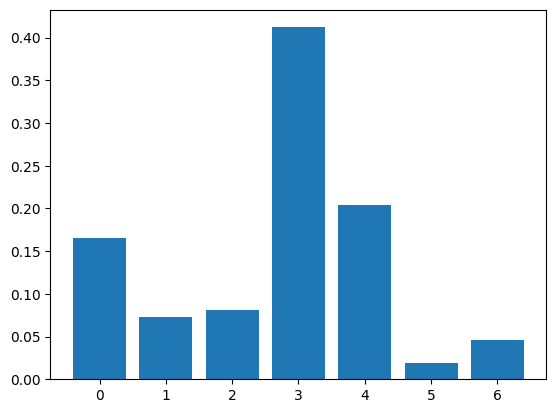


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	B  .  .  R  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	B  .  .  .  .  .  .
	B  .  .  R  .  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


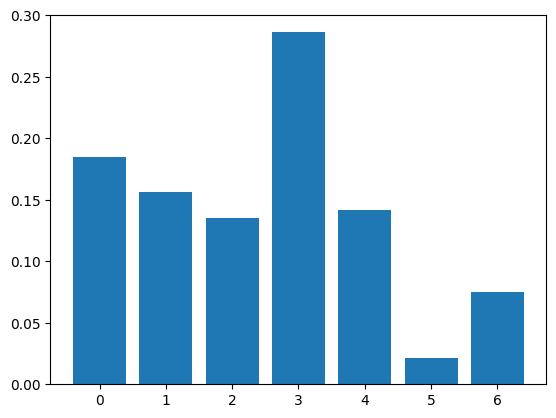


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	B  .  .  R  .  .  .
	B  .  .  R  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	B  .  .  .  .  .  .
	B  .  .  R  .  .  .
	B  .  .  R  .  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


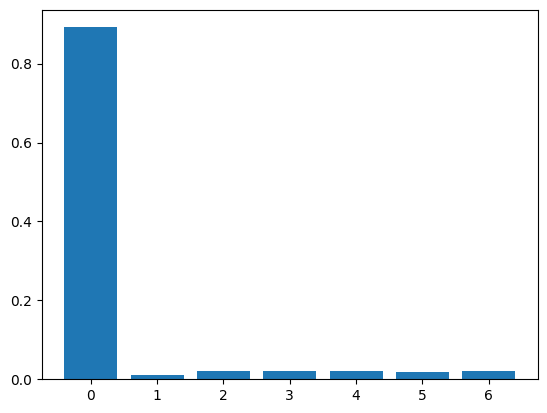


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  .  .  .  .
	B  .  .  R  .  .  .
	B  .  .  R  .  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  .  .  .
	B  .  .  R  .  .  .
	B  .  .  R  .  .  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


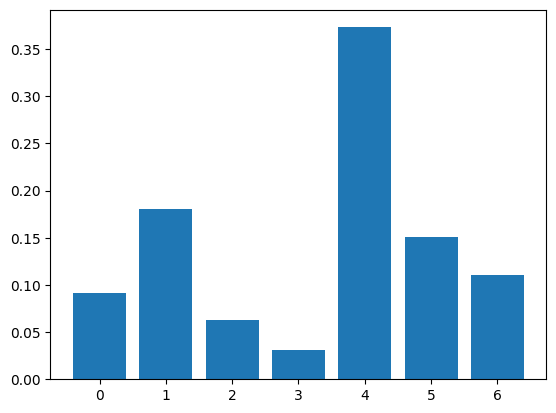


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  .  .  .
	B  .  .  R  .  .  .
	B  .  .  R  R  .  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  .  .  .
	B  .  .  R  .  .  .
	B  .  .  R  R  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


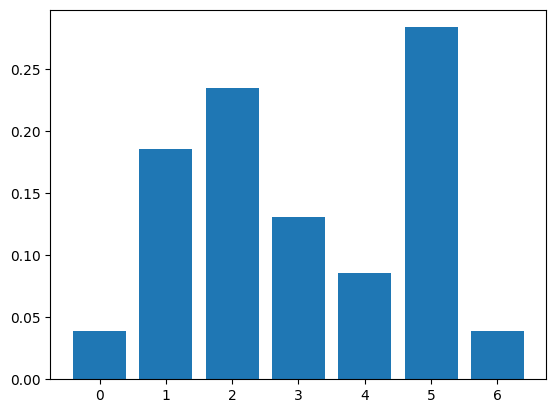


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  .  .  .
	B  .  .  R  .  R  .
	B  .  .  R  R  B  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  .  .  .
	B  .  .  R  B  R  .
	B  .  .  R  R  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


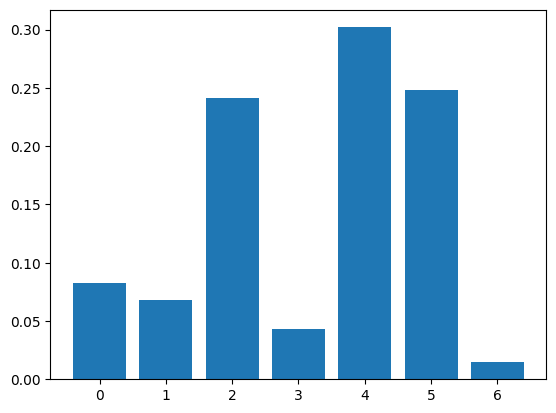


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  R  .  .
	B  .  .  R  B  R  .
	B  .  .  R  R  B  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  .  .  .
	B  .  .  B  R  .  .
	B  .  .  R  B  R  .
	B  .  B  R  R  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


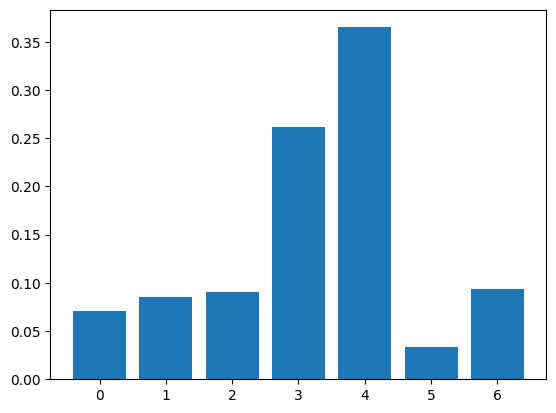


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  R  .  .
	B  .  .  B  R  .  .
	B  .  .  R  B  R  .
	B  .  B  R  R  B  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  .  R  .  .
	B  .  .  B  R  .  .
	B  .  B  R  B  R  .
	B  .  B  R  R  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


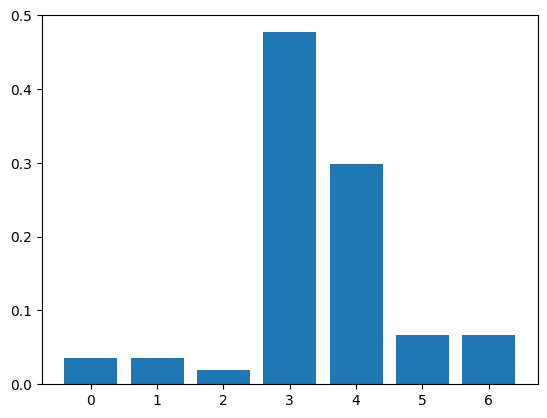


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  R  R  .  .
	B  .  .  B  R  .  .
	B  .  B  R  B  R  .
	B  .  B  R  R  B  .

player B is to play...
available actions: [0 1 2 3 4 5 6]

	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  R  R  .  .
	B  .  B  B  R  .  .
	B  .  B  R  B  R  .
	B  .  B  R  R  B  .

player R is to play...
available actions: [0 1 2 3 4 5 6]


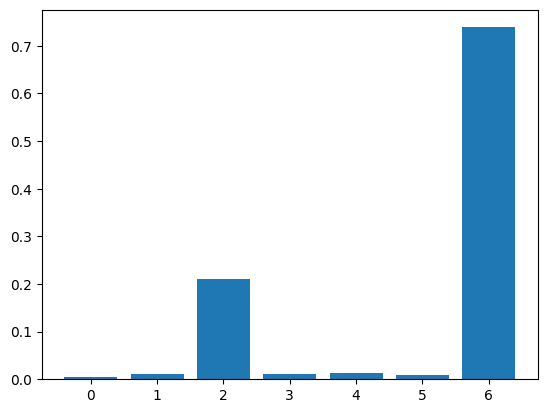


	.  .  .  .  .  .  .
	.  .  .  .  .  .  .
	R  .  .  R  R  .  .
	B  .  B  B  R  .  .
	B  .  B  R  B  R  .
	B  .  B  R  R  B  R

player R won!


In [51]:
c4 = Connect4()
player = c4.first_player
state = c4.init_state()
mcts = MCTS(c4, params)

while True:
    print_state(state)
    print(f"player {players[player]} is to play...")
    
    available_actions = c4.available_actions(state)
    print(f"available actions: {c4.available_actions(state)}")
    
    if len(available_actions) == 0:
        print("draw!")
        break

    if player == c4.first_player:
        action = int(input("provide a valid move: "))
    else:
        neutral_state = c4.neutral_perspective(state, player)
        policy = mcts.best_policy(neutral_state)
        action = np.argmax(policy)        

        plt.bar(range(len(policy)), policy)
        plt.show()
    
    state = c4.next_state(state, action, player)

    if c4.won(state, action):
        print_state(state)
        print(f"player {players[player]} won!")
        break
        
    player = c4.opponent(player)
        